## Redes Neuronales Hamiltonianas
### Problema de los 2 cuerpos

In [1]:
# Trabajo de Final de Grado, Grado en Física, 2022-2023
# Redes Neuronales Hamiltonianas
# Problema de los 2 cuerpos
# Francisco Jesús Frías Tenza

import warnings

import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.integrate import solve_ivp

import autograd
import autograd.numpy as np

import argparse
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow import keras
import tensorflow as tf

import pandas as pd

In [2]:
global m
m = [1, 1] #m1, m2

TASA_DE_APRENDIZAJE = 0.001       
CICLOS = 3000               
DIM_OCULTA = 200      

In [3]:
def U(estado):
    """
    La variable estado es una array de numpy organizada tal que

    [x1, y1, x2, y2, ...., xn, yn, vx1, vy1, vx2, vy2, ...]
    """
    energia_pot = 0
    for i in range(0, len(estado)//2, 2):
        for j in range(i+2, len(estado)//2, 2):
            r_ij = ((estado[i:i+2] - estado[j:j+2])**2).sum()**.5 # calcular distancias
            m_i, m_j = m[i//2], m[j//2]
        energia_pot += m_i * m_j / r_ij # asumimos que G = 1
    return -energia_pot

def T(estado):
    """
    La variable estado es una array de numpy organizada tal que

    [x1, y1, x2, y2, ...., xn, yn, vx1, vy1, vx2, vy2, ...]
    """
    energies = 0
    estado, destado = estado[:len(estado)//2], estado[len(estado)//2:]

    for i in range(0, len(destado), 2):
        mass_index = i//2
        energies += .5 * m[mass_index] * np.dot(destado[i:i+2], destado[i:i+2])
    return energies

def H(estado):
    """
    La variable estado es una array de numpy organizada tal que

    [x1, y1, x2, y2, ...., xn, yn, vx1, vy1, vx2, vy2, ...]
    """
    return U(estado) + T(estado)

In [4]:
print(T(np.array([1, 0, 0, 0, 1, 0, 0, 0])))

0.5


#### Generación de datos

In [5]:
def aceleracion(canon_coords, epsilon=0):
    """
    La variable estado es una array de numpy organizada tal que

    [x1, y1, x2, y2, ...., xn, yn, vx1, vy1, vx2, vy2, ...]
    """
    #print("aceleracion/estado", estado)
    Q, P = canon_coords[:len(canon_coords)//2], canon_coords[len(canon_coords)//2:]
    acc_list = []
    for cuerpo in range(0, Q.shape[0], 2):
        # Obtenemos el resto de cuerpos al que vamos a computar la acelarción
        resto_de_cuerpos = np.concatenate([Q[:cuerpo], Q[cuerpo+2:]], axis=-1)
        #print("resto de cuerpos", resto_de_cuerpos)
        r_ij = np.array([resto_de_cuerpos[j:j+2] - Q[cuerpo:cuerpo+2] for j in range(0, resto_de_cuerpos.shape[0], 2)])
        #print("r_ij", r_ij)
        mod_r_ij = np.array([np.linalg.norm(r_ij[k]) for k in range(len(r_ij))])
        mass_index = cuerpo // 2
        m_i, m_j = m[mass_index], np.concatenate([m[:mass_index], m[mass_index+1:]], axis=-1)
        #print("m_j", m_j, "r_ij", r_ij, "mod_r_ij", mod_r_ij, sep="\n")
        vectores_aceleracion = np.array([m_i * m_j[j] * r_ij[j] / (mod_r_ij[j]**3 + epsilon) for j in range(len(resto_de_cuerpos)//2)]) #m_ij * r_ij / (mod_r_ij**3 + epsilon) # G=1
        acc = vectores_aceleracion.sum(0) #aceleracion total para todos los cuerpos "j" sobre el cuerpo "i"
        acc_list.append(acc)
    acc_list = np.concatenate(acc_list, axis=0)
    #print("acc_lis", acc_list)
    return acc_list # np.array([ax1, ay1, ax2, ay2, ax3, ay3, ..., axn, ayn])
  
def Func(t, canon_coords):
    # Esta es la función que usamos para integrar el modelo
    #print("Func/estado", estado)
    F = np.zeros_like(canon_coords)
    F[:len(canon_coords)//2] = np.copy(canon_coords[len(canon_coords)//2:]) # Por si acaso, para evitar pasar referencias
    F[len(canon_coords)//2:] = aceleracion(canon_coords=canon_coords)
    return F
    # le hemos dado forma de [vx1, vy1, vx2, vy2, ..., vxn, vyn, ax1, ay1, ax2, ay2, ... ax1, ay1]

In [6]:
def generar_orbita(y0, F=Func, t_puntos=500, t_span=[0,10], hnn_modelo=None):
    ncuerpos = len(m)
    t_eval = np.linspace(t_span[0], t_span[1], t_puntos)
    atol = 1e-9; rtol = 1e-9
    kwargs = {'y0': y0, 't_span': t_span, 't_eval': t_eval, 'rtol': rtol, 'atol': atol}
    if (not hnn_modelo) and F:
        sol = solve_ivp(fun=F, **kwargs)
    elif hnn_modelo:
        sol = solve_ivp(fun=lambda t, x: hnn_modelo.compute_symplectic_gradient(tf.Variable(tf.reshape(x, (1, hnn_modelo.dim_entrada)), dtype='double')), **kwargs)

    orbita = sol['y']
    return orbita, t_eval

In [7]:
def y0(ruido=0, a=0.5, b=1.5, ncuerpos=2):
    canon_coords = np.zeros(ncuerpos*4) # 4 grados de libertad por cuerpo
    pos = np.random.rand(2) * (b-a) + a # posiscion inicial aleatoria
    r = np.sqrt( np.sum((pos**2)) )

    # velocidad para una órbita circular
    vel = np.flipud(pos) / (2 * r**1.5)
    vel[0] *= -1
    vel += ruido*np.random.randn()

    canon_coords = canon_coords.reshape(-1, 2)
    canon_coords[:len(canon_coords)//2,:] = pos
    canon_coords[len(canon_coords)//2:,:] = vel
    if ncuerpos == 2:
        canon_coords[1::2,:] *= -1
    return canon_coords.flatten()

In [20]:
def muestrear_orbitas(t_puntos=500, muestras=100, cuerpos=2, ruido=0,
                  a=0.5, b=1.5, t_span=[0, 20]):
    q1x_data, p1x_data, dq1xdt_data, dp1xdt_data = [], [], [], [] 
    q1y_data, p1y_data, dq1ydt_data, dp1ydt_data = [], [], [], [] 
    q2x_data, p2x_data, dq2xdt_data, dp2xdt_data = [], [], [], [] 
    q2y_data, p2y_data, dq2ydt_data, dp2ydt_data = [], [], [], [] 
    t_final = 5
    for _ in range(muestras):
        orbita, t_eval = generar_orbita(y0=y0())
        orbita += np.random.randn(*orbita.shape)*ruido
        for estado in orbita.T:
            destado = Func(None, canon_coords=estado)
            q1x_data.append(estado[0]); p1x_data.append(estado[4]); dq1xdt_data.append(destado[0]), dp1xdt_data.append(destado[4])
            q1y_data.append(estado[1]); p1y_data.append(estado[5]); dq1ydt_data.append(destado[1]), dp1ydt_data.append(destado[5])
            q2x_data.append(estado[2]); p2x_data.append(estado[6]); dq2xdt_data.append(destado[2]), dp2xdt_data.append(destado[6])
            q2y_data.append(estado[3]); p2y_data.append(estado[7]); dq2ydt_data.append(destado[3]), dp2ydt_data.append(destado[7])

    print(len(q1x_data))
    
    split_data = {
        "q1x": q1x_data,  # X set
        "q1y": q1y_data,  # X set

        "q2x": q2x_data,  # X set
        "q2y": q2y_data,  # X set

        "p1x": p1x_data,
        "p1y": p1y_data,

        "p2x": p2x_data,
        "p2y": p2y_data,

        "dq1x": dq1xdt_data, # Y set
        "dq1y": dq1ydt_data, # Y set

        "dq2x": dq2xdt_data, # Y set
        "dq2y": dq2ydt_data, # Y set

        "dp1x": dp1xdt_data,
        "dp1y": dp1ydt_data,

        "dp2x": dp2xdt_data,
        "dp2y": dp2ydt_data,
    }

    df = pd.DataFrame.from_dict(split_data, orient='columns')
    df.dropna(axis=0, how='any', inplace=True)

    return df

In [9]:
def plot_figures_compare(x1, y1, x2, y2, v1x, v1y, v2x, v2y):

    fig, axs = plt.subplots(ncols=3, nrows=2)
    gs = axs[0, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[:, 1:].flatten():
        ax.remove()
    axbig = fig.add_subplot(gs[:, 1:])
    fig.tight_layout()

    axs[0,0].plot(x1, y1, "b--", label="Cuerpo 1")
    axs[0,0].grid()
    axs[0,0].legend()
    axs[0,0].set_title("Cuerpo 1")
    axs[1,0].plot(x2, y2, "r--", label="Cuerpo 2")
    axs[1,0].grid()
    axs[1,0].legend()
    axs[1,0].set_title("Cuerpo 2")

    axbig.plot(x1, y1, "b--", label="Cuerpo 1")
    axbig.plot(x2, y2, "r--", label="Cuerpo 2")
    axbig.grid()
    axbig.legend()
    axbig.set_title("Camino seguido por los dos cuerpos")

    plt.show()  

(500, 8)


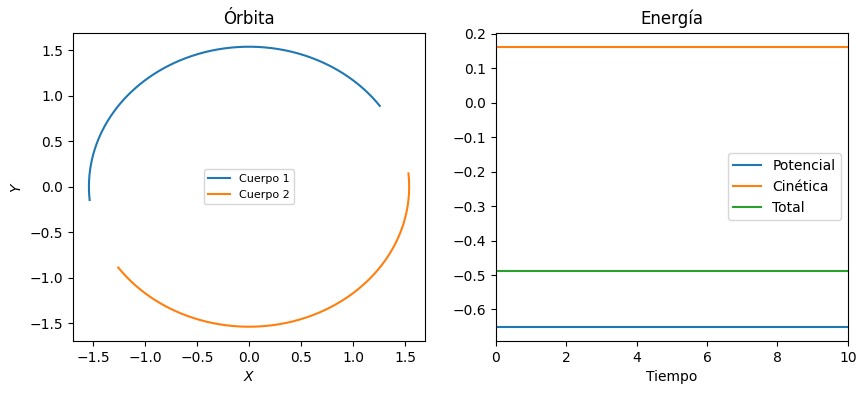

In [10]:
estado_inicial = y0()
orbita, t_eval = generar_orbita(estado_inicial)
print(orbita.T.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1) #plt.figure(figsize=[10,4], dpi=100)
fig.set_size_inches(10, 4)
fig.set_dpi(100)

ax1.set_title('Órbita')
ax1.plot(orbita[0], orbita[1], label='Cuerpo 1')
ax1.plot(orbita[2], orbita[3], label='Cuerpo 2')
ax1.set_xlabel('$X$') ; ax1.set_ylabel('$Y$')
ax1.legend(fontsize=8)

ax2.set_title('Energía') ; ax2.set_xlabel('Tiempo')
T_values = [T(estado=estado) for estado in orbita.T]; 
U_values = [U(estado=estado) for estado in orbita.T] 
H_values = [H(estado=estado) for estado in orbita.T]

ax2.plot(t_eval, U_values, label='Potencial')
ax2.plot(t_eval, T_values, label='Cinética')
ax2.plot(t_eval, H_values, label='Total')
ax2.legend()
ax2.set_xlim((t_eval[0], t_eval[-1]))

plt.show()

In [11]:
class HNN(tf.Module):
  
  def __init__(self, dim_entrada, dim_oculta, name=None):
    super().__init__(name=name)
    self.dim_entrada = dim_entrada
    self.dim_oculta = dim_oculta
    self.capa1 = tf.keras.layers.InputLayer(input_shape=self.dim_entrada) # Input layer
    self.capa2 = tf.keras.layers.Dense(units=self.dim_oculta, activation='tanh')
    # Si se busca crear más capas, ha de copiarse y pegar el siguiente código
    # self.capa_n = tf.keras.layers.Dense(units=dim_oculta, activation='tanh') # donde "_n" es u numero natural
    self.capa4 = tf.keras.layers.Dense(1) # Output layer
    O = np.zeros((dim_entrada//2, dim_entrada//2))
    I = np.identity(dim_entrada//2)
    R_90 = np.concatenate([np.concatenate((O, I), axis=1), np.concatenate((-I, O), axis=1)], axis=0)
    self.R_90 = tf.constant(R_90, dtype='double')

  @tf.Module.with_name_scope
  def __call__(self, x):
    y = self.capa1(x)
    y = self.capa2(y)
    y = self.capa4(y)
    return y
  
  def compute_symplectic_gradient(self, x):
    with tf.GradientTape() as tape:
      y = self.capa1(x)
      y = self.capa2(y)
      y = self.capa4(y)
    y = tape.gradient(y, x)
    y = y @ tf.constant(np.linalg.inv(self.R_90), dtype='double')
    return y
  
  def entrenar_HNN(self, data, tasa_de_aprendizaje = TASA_DE_APRENDIZAJE, ciclos = CICLOS):
    warnings.filterwarnings('ignore')
    loss_array = np.zeros(ciclos+1)
    # Tomamos el algoritmo Adam para optimización
    adam_aldoritmo = tf.keras.optimizers.Adam(learning_rate=tasa_de_aprendizaje)
    # Declaramos la función de coste
    funcion_coste_L2 = tf.keras.losses.MeanSquaredError()
    ciclo = 0
    while ciclo <= ciclos:
        with tf.GradientTape() as tape_coste: # Este es el gradiente de la función de coste
            tape_coste.watch(self.trainable_variables) # Esto nos permite 'vigilar' las variables de TensorFlow
            y_train_keys = [key for key in data.columns if 'd' in key]
            y_test_keys = [key for key in data.columns if 'd' not in key]
            y_pred = self.compute_symplectic_gradient(tf.Variable(tf.stack(data[y_test_keys]))) # SympGrad del Hamiltoniano
            y_real = tf.Variable(tf.stack(data[y_train_keys]))
            loss = funcion_coste_L2(y_pred=y_pred, y_true=y_real) # Evaluación de la función de coste
        # Creamos el gradiente
        gradiente_funcion_coste_L2 = tape_coste.gradient(loss, self.trainable_variables)
        # El siguiente paso es opcional, usamos esto para agilizar el entrenamiento
        adam_aldoritmo.apply_gradients(zip(gradiente_funcion_coste_L2, self.trainable_variables))
        print(ciclo, loss)
        loss_array[ciclo] = loss
        ciclo += 1
    warnings.resetwarnings()

    return loss_array


In [23]:
dataset = muestrear_orbitas()

entrenar_todos = False
t_puntos = 2000
t_span = [0,50]

hnn_model_100 = HNN(dim_entrada=8, dim_oculta=100, name="HNN_2cuerpos_100")
loss_array_100 = hnn_model_100.entrenar_HNN(data=dataset, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS)

if entrenar_todos:
    hnn_model_200 = HNN(dim_entrada=8, dim_oculta=200, name="HNN_2cuerpos_200")
    loss_array_200 = hnn_model_200.entrenar_HNN(data=dataset, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS)

    hnn_model_300 = HNN(dim_entrada=8, dim_oculta=300, name="HNN_2cuerpos_300")
    loss_array_300 = hnn_model_300.entrenar_HNN(data=dataset, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS)

    hnn_model_400 = HNN(dim_entrada=8, dim_oculta=400, name="HNN_2cuerpos_400")
    loss_array_400 = hnn_model_400.entrenar_HNN(data=dataset, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS)

orbita, t_eval = generar_orbita(y0=estado_inicial, t_puntos=t_puntos, t_span=t_span)

hnn_orbita_100, t_eval = generar_orbita(y0=estado_inicial, t_puntos=t_puntos, t_span=t_span, hnn_modelo=hnn_model_100)

if entrenar_todos:
    hnn_orbita_200, t_eval = generar_orbita(y0=estado_inicial, t_puntos=t_puntos, t_span=t_span, hnn_modelo=hnn_model_200)
    hnn_orbita_300, t_eval = generar_orbita(y0=estado_inicial, t_puntos=t_puntos, t_span=t_span, hnn_modelo=hnn_model_300)
    hnn_orbita_400, t_eval = generar_orbita(y0=estado_inicial, t_puntos=t_puntos, t_span=t_span, hnn_modelo=hnn_model_400)

50000
0 tf.Tensor(0.0724610699304589, shape=(), dtype=float64)
1 tf.Tensor(0.0679933900500325, shape=(), dtype=float64)
2 tf.Tensor(0.06390417284641486, shape=(), dtype=float64)
3 tf.Tensor(0.06018847559908877, shape=(), dtype=float64)
4 tf.Tensor(0.05683328676656405, shape=(), dtype=float64)
5 tf.Tensor(0.05381589326218611, shape=(), dtype=float64)
6 tf.Tensor(0.051107907866760734, shape=(), dtype=float64)
7 tf.Tensor(0.04868201155274846, shape=(), dtype=float64)
8 tf.Tensor(0.0465153507401021, shape=(), dtype=float64)
9 tf.Tensor(0.04458917825392855, shape=(), dtype=float64)
10 tf.Tensor(0.042887373901154144, shape=(), dtype=float64)
11 tf.Tensor(0.041395175997561616, shape=(), dtype=float64)
12 tf.Tensor(0.04009800537059037, shape=(), dtype=float64)
13 tf.Tensor(0.0389804988596163, shape=(), dtype=float64)
14 tf.Tensor(0.03802603363903143, shape=(), dtype=float64)
15 tf.Tensor(0.03721687578032293, shape=(), dtype=float64)
16 tf.Tensor(0.03653493587652538, shape=(), dtype=float64)
17

(None, None)

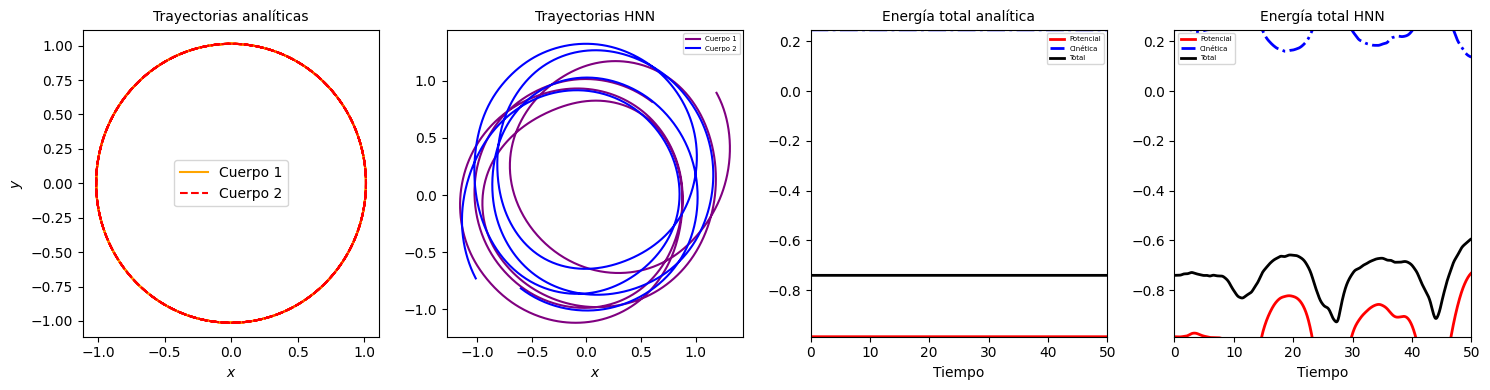

In [ ]:
fig, (ax1, ax12, ax2, ax3) = plt.subplots(ncols=4, nrows=1)
fig.set_size_inches(15, 4)
fig.tight_layout(pad=1.1, h_pad=3, w_pad=3)
fig.set_dpi(100)

ax1.set_title('Trayectorias analíticas', fontsize=10)
colores = ['orange', 'red', 'purple', 'blue']
ax1.plot(orbita[0], orbita[1], color=colores[0], label="Cuerpo 1")
ax1.plot(orbita[2], orbita[3], "r--", label="Cuerpo 2")

ax1.set_xlabel('$x$', fontsize=10) ; ax1.set_ylabel('$y$', fontsize=10)
ax1.legend(fontsize=10)

ax12.set_title('Trayectorias HNN', fontsize=10)
ax12.plot(hnn_orbita_100[0], hnn_orbita_100[1], color=colores[2], label="Cuerpo 1")
ax12.plot(hnn_orbita_100[2], hnn_orbita_100[3], color=colores[3], label="Cuerpo 2")

ax12.set_xlabel('$x$', fontsize=10) ; ax1.set_ylabel('$y$', fontsize=10)
ax12.legend(fontsize=5)

T_values = np.array([T(estado=estado) for estado in orbita.T]); 
U_values = np.array([U(estado=estado) for estado in orbita.T]) 
H_values = np.array([H(estado=estado) for estado in orbita.T])

ax2.set_title('Energía total analítica', fontsize=10)
ax2.set_xlabel('Tiempo')
ax2.plot(t_eval, U_values, 'r-', label='Potencial', linewidth=2)
ax2.plot(t_eval, T_values, 'b-.', label='Cinética', linewidth=2)
ax2.plot(t_eval, H_values, 'k-', label='Total', linewidth=2)
ax2.legend(fontsize=5)
ax2.set_xlim((t_eval[0], t_eval[-1]))
ymin = np.min([U_values.min(), T_values.min(), H_values.min()])
ymax = np.max([U_values.max(), T_values.max(), H_values.max()])
ax2.set_ylim(ymin, ymax)


T_values_hnn = np.array([T(estado=estado) for estado in hnn_orbita_100.T]); 
U_values_hnn = np.array([U(estado=estado) for estado in hnn_orbita_100.T] )
H_values_hnn = np.array([H(estado=estado) for estado in hnn_orbita_100.T])

ax3.set_title('Energía total HNN', fontsize=10)
ax3.set_xlabel('Tiempo')
ax3.plot(t_eval, U_values_hnn, 'r-', label='Potencial', linewidth=2)
ax3.plot(t_eval, T_values_hnn, 'b-.', label='Cinética', linewidth=2)
ax3.plot(t_eval, H_values_hnn, 'k-', label='Total', linewidth=2)
ax3.legend(fontsize=5)
ax3.set_xlim((t_eval[0], t_eval[-1]))
ax3.set_ylim(ymin, ymax)

plt.tight_layout(), fig.savefig(r".\img\2body2")

NameError: name 'loss_array_100' is not defined

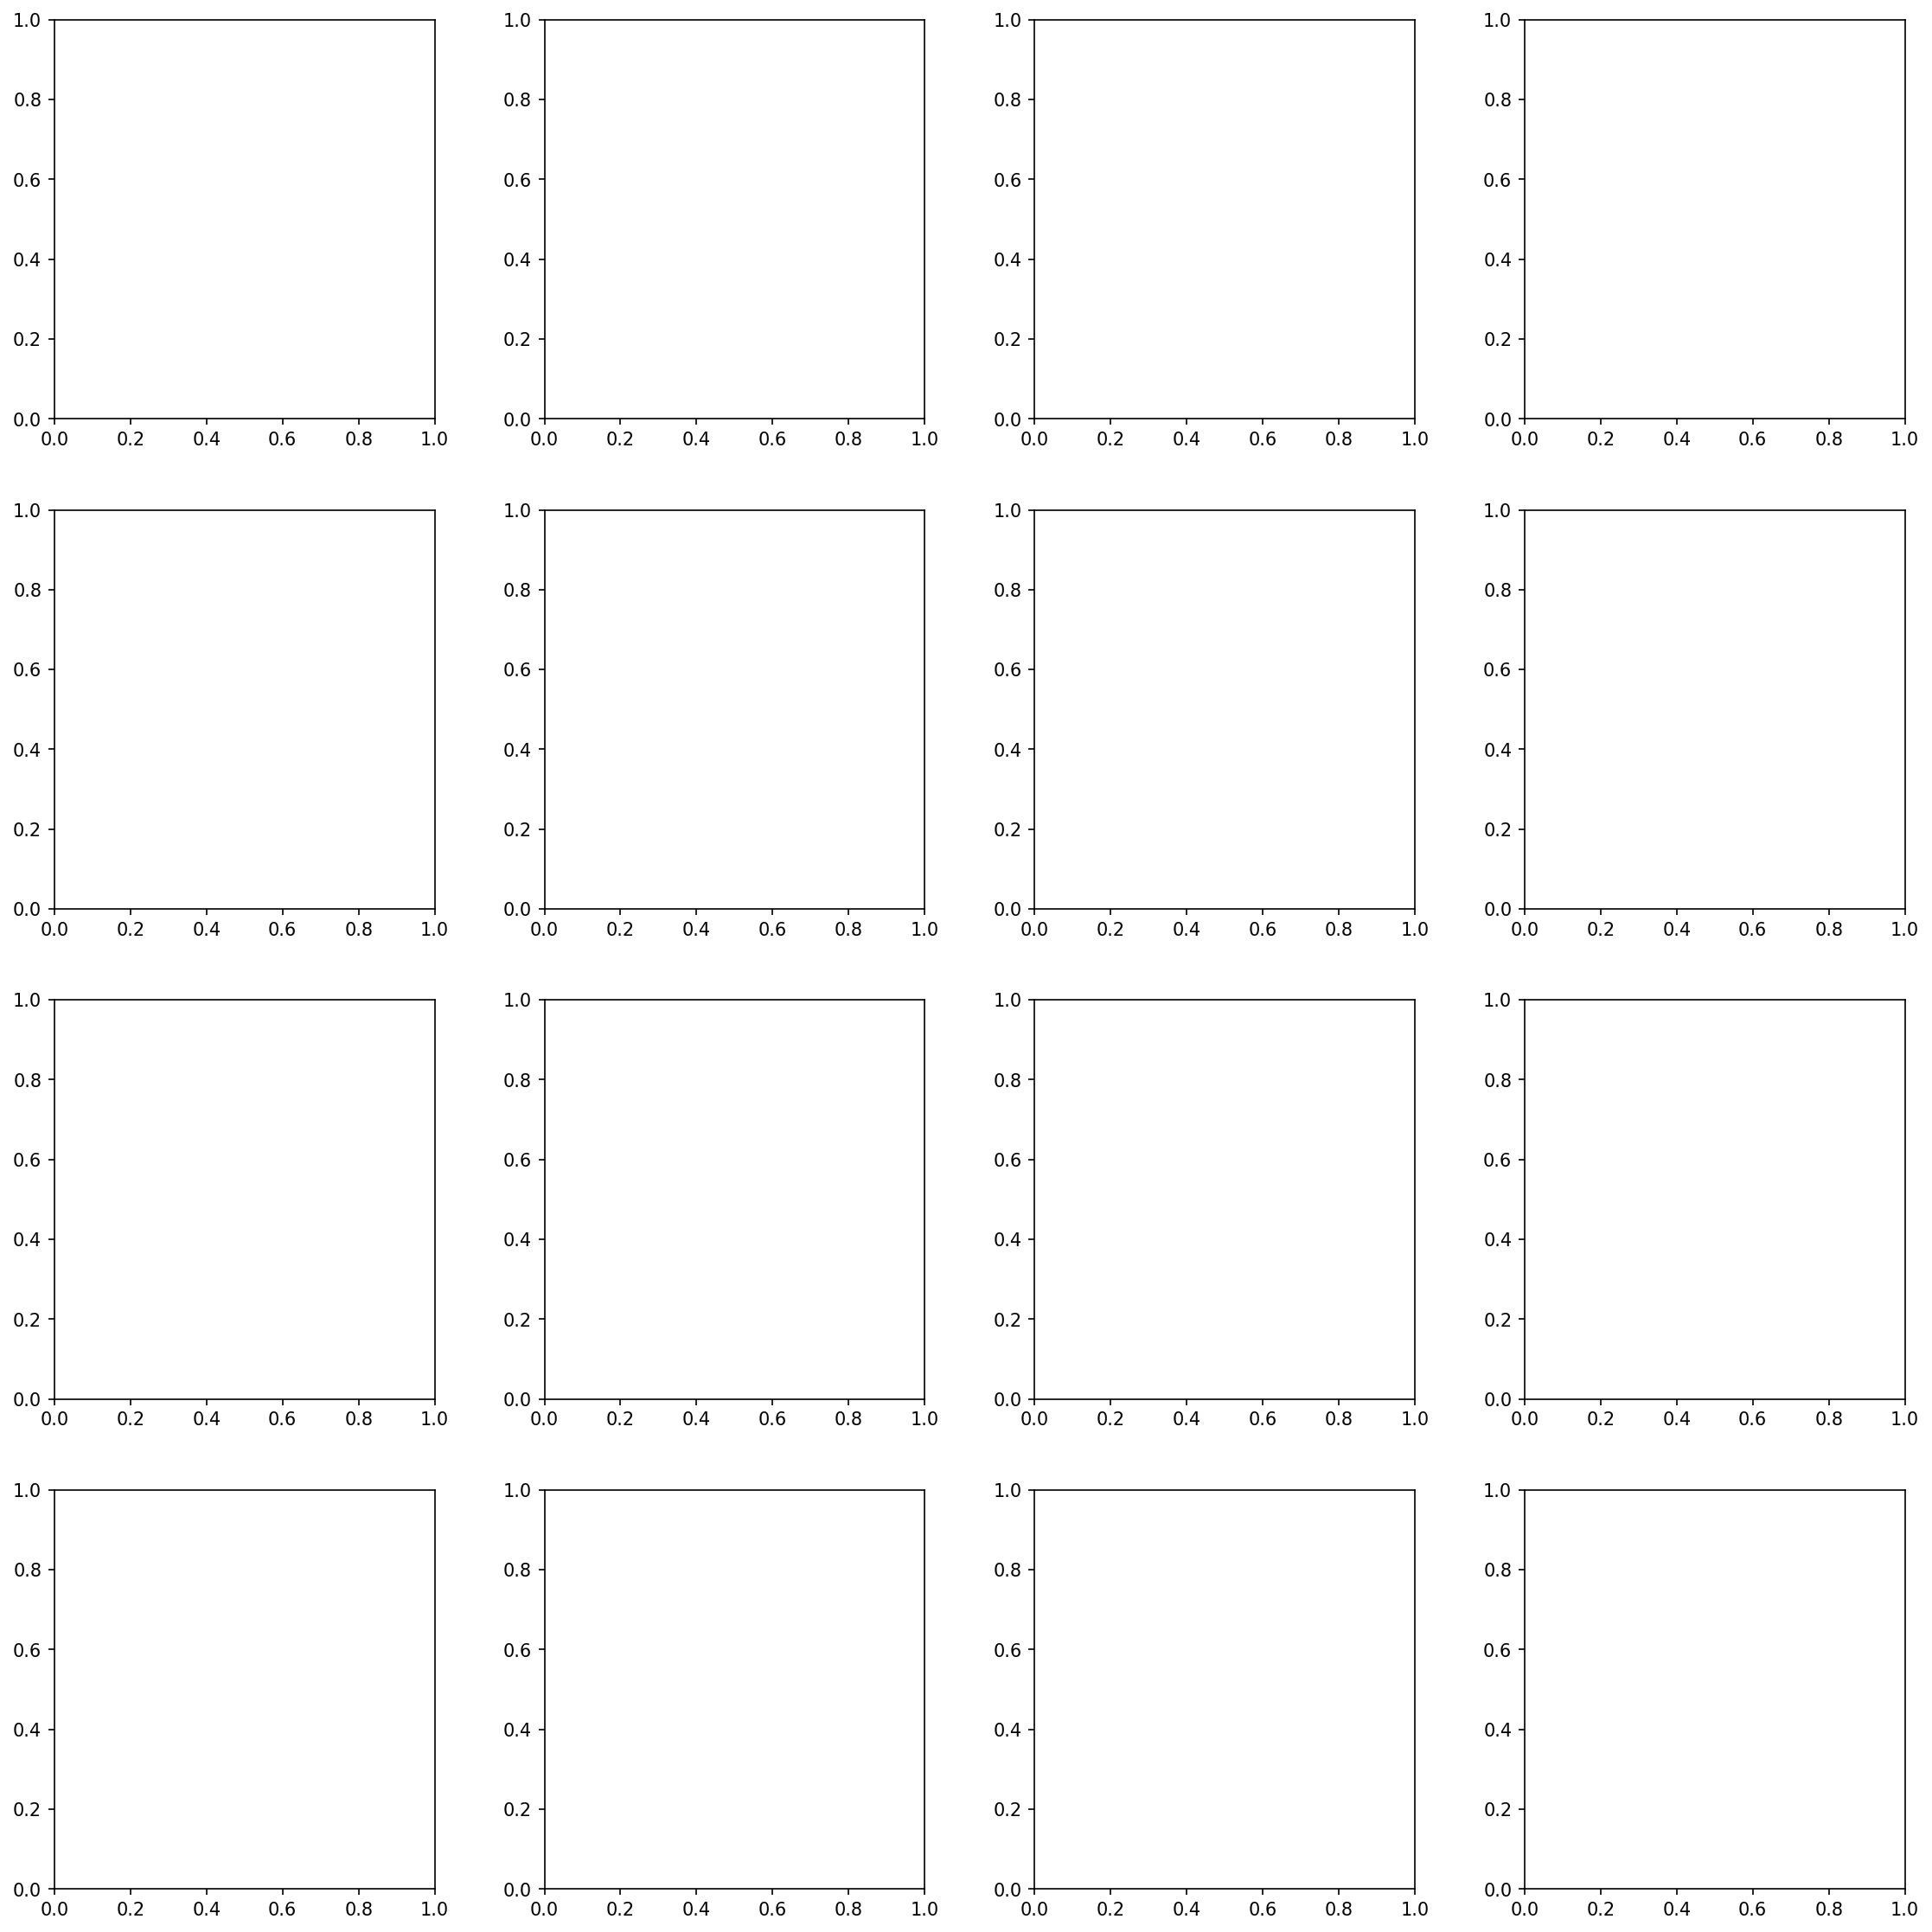

In [22]:

if entrenar_todos:
    
    ncols, nrows = 4, 4
    colores = ['orange', 'red', 'purple', 'blue']


    fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
    fig.set_size_inches(15, 15)
    fig.set_dpi(150)
    fig.tight_layout(pad=1.1, h_pad=3, w_pad=3)


    loss_array = np.array([loss_array_100, loss_array_200, loss_array_300, loss_array_400])
    hnn_orbitas = np.array([hnn_orbita_100, hnn_orbita_200, hnn_orbita_300, hnn_orbita_400])

    for row in range(nrows):

        axs[row,0].set_title('Trayectorias analíticas', fontsize=10)
        axs[row,0].plot(orbita[0], orbita[1], color=colores[0], label="Cuerpo 1")
        axs[row,0].plot(orbita[2], orbita[3], "r--", label="Cuerpo 2")

        axs[row,0].set_xlabel('$x$', fontsize=10) ; axs[row,0].set_ylabel('$y$', fontsize=10)
        #axs[row,0].legend(fontsize=fs)

        axs[row,1].set_title('Trayectorias HNN', fontsize=10)
        axs[row,1].plot(hnn_orbitas[row,0], hnn_orbitas[row,1], color=colores[2], label="Cuerpo 1")
        axs[row,1].plot(hnn_orbitas[row,2], hnn_orbitas[row,3], color=colores[3], label="Cuerpo 2")

        axs[row,1].set_xlabel('$x$', fontsize=10) ; ax1.set_ylabel('$y$', fontsize=10)
        #axs[row,1].legend(fontsize=fs)

        #T_values = np.array([T(estado=estado) for estado in orbita.T]); 
        #U_values = np.array([U(estado=estado) for estado in orbita.T]) 
        #H_values = np.array([H(estado=estado) for estado in orbita.T])
    #
        #axs[row,2].set_title('Energía total analítica', fontsize=ts, pad=tpad)
        #axs[row,2].set_xlabel('Tiempo')
        #axs[row,2].plot(t_eval, U_values, 'g:', label='Potencial', linewidth=lw)
        #axs[row,2].plot(t_eval, T_values, 'c-.', label='Cinética', linewidth=lw)
        #axs[row,2].plot(t_eval, H_values, 'k-', label='Total', linewidth=lw)
        ##axs[row,2].legend(fontsize=fs)
        #axs[row,2].set_xlim((t_eval[0], t_eval[-1]))
        #ymin = np.min([U_values.min(), T_values.min(), H_values.min()])
        #ymax = np.max([U_values.max(), T_values.max(), H_values.max()])
        #axs[row,2].set_ylim(ymin, ymax)


        T_values_hnn = np.array([T(estado=estado) for estado in hnn_orbitas[row].T]) 
        U_values_hnn = np.array([U(estado=estado) for estado in hnn_orbitas[row].T])
        H_values_hnn = np.array([H(estado=estado) for estado in hnn_orbitas[row].T])

        axs[row,2].set_title('Energía total HNN', fontsize=10)
        axs[row,2].set_xlabel('Tiempo')
        axs[row,2].plot(t_eval, U_values_hnn, 'r-', label='Potencial', linewidth=2)
        axs[row,2].plot(t_eval, T_values_hnn, 'b-.', label='Cinética', linewidth=2)
        axs[row,2].plot(t_eval, H_values_hnn, 'k-', label='Total', linewidth=2)
        #axs[row,3].legend(fontsize=fs)
        axs[row,2].set_xlim((t_eval[0], t_eval[-1]))
        axs[row,2].set_ylim(ymin, ymax)

        axs[row,3].plot(np.arange(0, len(loss_array[row]), 1), loss_array[row], label="coste")
        axs[row,3].set_title(r'Optimización de $\Lambda$', fontsize=10)
        axs[row,3].set_xlabel('Iteraciones')
        axs[row,3].set_ylabel(r'\Lambda')
        #axs[row,4].legend(fontsize=fs)


    fig.tight_layout(pad=1.05) ;fig.savefig(r'.\img\2body_many_neurons')